In [1]:
from glob import glob
import os
from random import seed, sample
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras import layers, models
from keras.optimizers import SGD, Adam
from keras. callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
batch_size = 128
epochs = 120
amount = 100000

In [3]:
path1 = 'E:\\deeplearning\\Hepatocarcinomes\\models\\10x\\vgg16_dense_bn'
path = 'E:\\deeplearning\\Hepatocarcinomes\\data\\10x\\training\\split128_image'

In [4]:
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(128,128,3), pooling=None)

In [5]:
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(4096, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(2, activation = 'softmax')(x)

In [6]:
model = models.Model(input=base_model.input, output=predictions)

C:\Program Files\Anaconda3\envs\r-tensorflow\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [7]:
# model.summary()

In [8]:
# model.compile(optimizer = SGD(lr = 1e-2, decay=0.001, momentum=0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [10]:
glob_tum_imgs = os.path.join(path, 'neg_tum_5k\\*\\*.tif')
glob_nor_imgs = os.path.join(path, 'pos_nor_5k\\*\\*.tif')

train_tum_paths = glob(glob_tum_imgs)
train_nor_paths = glob(glob_nor_imgs)
print(len(train_tum_paths), len(train_nor_paths))

seed(1)
train_tum_paths = sample(train_tum_paths, amount)
train_nor_paths = sample(train_nor_paths, amount)
# print(len(train_tum_paths), len(train_nor_paths))

# Split the data into a train and validation set
train_tum_paths, val_tum_paths = train_test_split(train_tum_paths, test_size=0.2)
train_nor_paths, val_nor_paths = train_test_split(train_nor_paths, test_size=0.2)

train_paths = train_nor_paths + train_tum_paths 
val_paths = val_nor_paths + val_tum_paths

np.random.seed(1)
np.random.shuffle(train_paths)
np.random.shuffle(val_paths)
# print(val_paths[:10])

189505 142098


In [11]:
y_train = np.vstack((np.ones(int(amount*0.8), np.float32), np.zeros(int(amount*0.8), np.float32))) #pos is 0
y_val = np.vstack((np.ones(int(amount*0.2), np.float32), np.zeros(int(amount*0.2), np.float32)))

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)

np.random.seed(1) 
np.random.shuffle(y_train)
np.random.shuffle(y_val)

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)

# print(y_val[:10])

In [12]:
# Write it like a normal function
def image_gen(img_paths, y, img_size=(128, 128)):
    # Iterate over all the image paths
    for i in range(len(img_paths)):
        
        # Load the image and mask, and normalize it to 0-1 range
        img = cv2.cvtColor(cv2.imread(img_paths[i], -1), cv2.COLOR_BGR2RGB)/255
        label = y[i]
        
        # Yield the image mask pair
        yield img, label
        
# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, y, batchsize=32):
    while True:
        ig = image_gen(img_paths, y)
        batch_img, batch_label = [], []
        
        for img, label in ig:
            # Add the image and label to the batch
            batch_img.append(img)
            batch_label.append(label)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_label, axis=0)
                batch_img, batch_label = [], []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.stack(batch_label, axis=0)
            batch_img, batch_label = [], []    
            
# Create the train and validation generators
traingen = image_batch_generator(train_paths, y_train, batchsize=batch_size)
valgen = image_batch_generator(val_paths, y_val, batchsize=batch_size)

In [13]:
print(int(amount*1.6)//128)

1250


In [14]:
def calc_steps(data_len, batchsize):
    print(data_len / batchsize)
    if data_len%batchsize==0:
        return (data_len // batchsize) 
    else:
        return (data_len // batchsize - 1)

# Calculate the steps per epoch
train_steps = calc_steps(int(amount*1.6), batch_size)
val_steps = calc_steps(int(amount*0.4), batch_size)

csv_logger = CSVLogger(path1+'\\adam_64_lr3_training.csv', append=True)
model_checkpoint = ModelCheckpoint(path1+'\\3_adam_64_lr3_weights.{epoch:02d}-{val_acc:.4f}.hdf5',verbose=1, save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, min_delta=0.005, cooldown=3, patience=8, verbose=1)
# we could also set the parameter 'smax_queue_size' based on memory restriction
results = model.fit_generator(traingen, train_steps, epochs=100, verbose=1, callbacks=[csv_logger, model_checkpoint, early_stop, reduce_lr], validation_data=valgen, validation_steps=val_steps)
csv_logger.csv_file.close()

1250.0
312.5
Epoch 1/100
1250/1250 [==============================] - 807s 645ms/step - loss: 0.4053 - acc: 0.8228 - val_loss: 0.5634 - val_acc: 0.7872
Epoch 2/100
1250/1250 [==============================] - 746s 597ms/step - loss: 0.2774 - acc: 0.8916 - val_loss: 0.5606 - val_acc: 0.8102
Epoch 3/100
1250/1250 [==============================] - 748s 598ms/step - loss: 0.2320 - acc: 0.9125 - val_loss: 0.6017 - val_acc: 0.8039

Epoch 00003: val_loss improved from inf to 0.60167, saving model to E:\deeplearning\Hepatocarcinomes\models\10x\vgg16_dense_bn\adam_64_lr3_weights.03-0.8039.hdf5
Epoch 4/100
1250/1250 [==============================] - 757s 606ms/step - loss: 0.2021 - acc: 0.9242 - val_loss: 0.2640 - val_acc: 0.9017
Epoch 5/100
1250/1250 [==============================] - 753s 602ms/step - loss: 0.1828 - acc: 0.9327 - val_loss: 0.2081 - val_acc: 0.9227
Epoch 6/100
1250/1250 [==============================] - 747s 598ms/step - loss: 0.1648 - acc: 0.9405 - val_loss: 0.2031 - val_ac

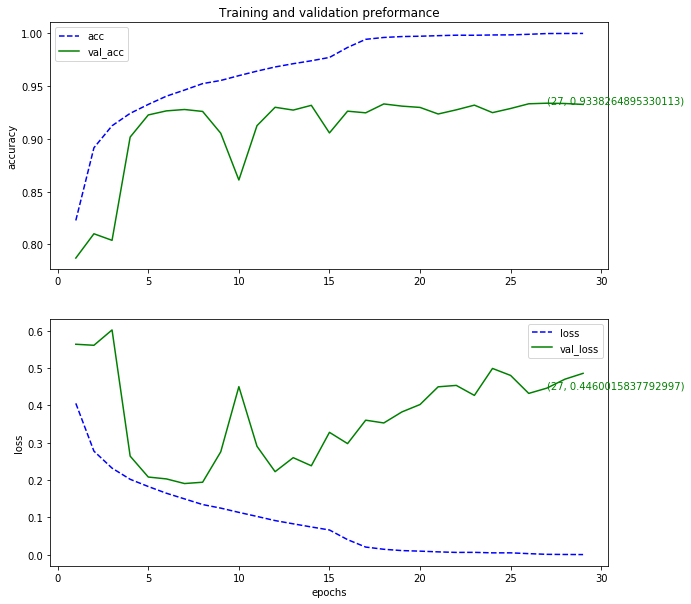

In [15]:
#plot training results
acc=results.history['acc']
val_acc=results.history['val_acc']
loss=results.history['loss']
val_loss=results.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.ylabel('accuracy')
# plt.ylim((0, 5))

epochs=range(1, len(acc)+1)
plt.plot(epochs,acc,'b--',label='acc')
plt.plot(epochs, val_acc,'g',label='val_acc')
index0=np.where(val_acc==np.amax(val_acc))[0]
if(len(index0)>3):
    for i in range(2):
        plt.text(epochs[int(i)], val_acc[int(i)], str((epochs[int(i)], val_acc[int(i)])),color='g')
else:
    for i in index0:
        plt.text(epochs[int(i)], val_acc[int(i)], str((epochs[int(i)], val_acc[int(i)])),color='g')
    
plt.title('Training and validation preformance')
plt.legend()

plt.subplot(2,1,2)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim((0, 5))

epochs=range(1, len(loss)+1)
plt.plot(epochs,loss,'b--',label='loss')
plt.plot(epochs, val_loss,'g',label='val_loss')
if(len(index0)>3):
    for i in range(2):
        plt.text(epochs[int(i)], val_loss[int(i)], str((epochs[int(i)], val_loss[int(i)])),color='g')
else:
    for i in index0:
        plt.text(epochs[int(i)], val_loss[int(i)], str((epochs[int(i)], val_loss[int(i)])),color='g')
    
plt.legend()
plt.savefig(path1+'\\adam_64_lr4_training_validation_performance')
plt.show()

In [16]:
model.save(path1 + '\\adam_64_lr3_best_model.hdf5')

In [17]:
del(model)

####best parameters:
50k: batch_size=128, optimizer=Adam (lr=3)
